In [261]:
import pandas as pd
import numpy as np
import numpy.ma as ma

In [262]:
# Load the dataset
data = pd.read_csv("employee_data.csv")
data

,Salary,Job Satisfaction,Years of Experience,Employment Status
0,56.217808,2.666196,7,stay
1,96.550001,5.877109,3,stay
2,81.239576,8.856513,14,stay
3,71.906094,7.590024,10,stay
4,40.921305,8.259050,16,stay
...,...,...,...,...
995,36.410745,6.912596,19,leave
996,94.211950,9.609532,1,stay
997,39.577304,1.620622,7,leave
998,96.516615,1.513492,17,stay


In [263]:
# Check for missing values
data.isnull().sum()

Salary                 0
Job Satisfaction       0
Years of Experience    0
Employment Status      0
dtype: int64

In [264]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=["Employment Status"])
y = data["Employment Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

In [265]:
def calculate_gini_impurity(y):
    classes = np.unique(y)
    gini = 0
    total_samples = len(y)
    for cls in classes:
        p = np.sum(y == cls) / total_samples
        gini += p * (1 - p)
    return gini

In [266]:
def calculate_entropy(y):
    classes = np.unique(y)
    entropy = 0
    total_samples = len(y)
    for cls in classes:
        p = np.sum(y == cls) / total_samples
        entropy -= p * np.log2(p)
    return entropy

In [267]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


In [268]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.root = None
        self.criterion = "gini"
        self.max_depth = max_depth

    def _best_split(self, X, y):
        best_gini = np.inf
        best_feature_idx = None
        best_threshold = None

        for feature_idx in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] < threshold
                right_indices = X[:, feature_idx] >= threshold

                gini_left = calculate_gini_impurity(y[left_indices])
                gini_right = calculate_gini_impurity(y[right_indices])
                gini = (
                        len(y[left_indices]) * gini_left
                        + len(y[right_indices]) * gini_right
                    ) / len(y)

                if gini < best_gini:
                    best_gini = gini
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return TreeNode(value=y[0])

        if self.max_depth is not None and depth >= self.max_depth:
            return TreeNode(value=np.bincount(y).argmax())

        best_feature_idx, best_threshold = self._best_split(X, y)

        if best_feature_idx is None:
            return TreeNode(value=np.bincount(y).argmax())

        left_indices = X[:, best_feature_idx] < best_threshold
        right_indices = X[:, best_feature_idx] >= best_threshold

        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return TreeNode(
            feature=best_feature_idx,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
        )

    def fit(self, X, y):
        self.root = self._build_tree(X, y, depth=0)

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        predictions = []
        for x in X:
            predictions.append(self._predict_one(x, self.root))
        return np.array(predictions)

In [269]:
tree = DecisionTree( max_depth=None)

tree.fit(X_train.values, y_train.values)

test_predictions = tree.predict(X_test.values)

accuracy = np.mean(test_predictions == y_test)

print("Accuracy:", accuracy)

Accuracy: 1.0


In [270]:
new_employee_data = np.array([[75, 7, 5]])
prediction = tree.predict(new_employee_data)
print("Predicted employment status:", prediction[0])

Predicted employment status: stay


C:\Users\arshad\AppData\Local\Temp\ipykernel_20380\1420175871.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


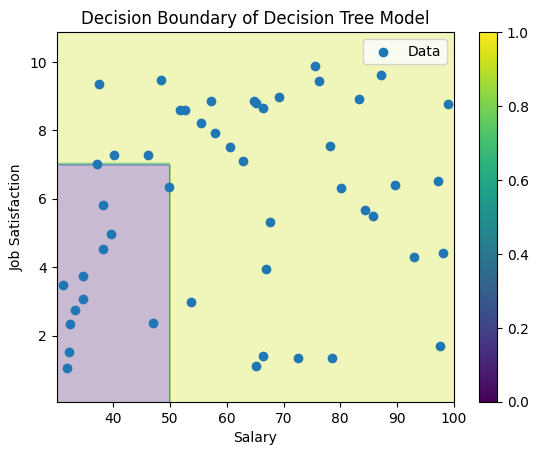

In [271]:
import matplotlib.pyplot as plt

data_5_years_exp = data[data["Years of Experience"] == 5]

x_min, x_max = (
    data_5_years_exp["Salary"].min() - 1,
    data_5_years_exp["Salary"].max() + 1,
)
y_min, y_max = (
    data_5_years_exp["Job Satisfaction"].min() - 1,
    data_5_years_exp["Job Satisfaction"].max() + 1,
)
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

mesh_data = np.c_[
    xx.ravel(), yy.ravel(), np.ones_like(xx.ravel()) * 5
]  
Z = tree.predict(mesh_data).reshape(xx.shape)

Z_numeric = np.where(Z == "leave", 0, 1)

plt.contourf(xx, yy, Z_numeric, alpha=0.3, cmap="viridis")
plt.scatter(
    data_5_years_exp["Salary"],
    data_5_years_exp["Job Satisfaction"],
    cmap="viridis",
    label="Data",
)
plt.xlabel("Salary")
plt.ylabel("Job Satisfaction")
plt.title("Decision Boundary of Decision Tree Model")
plt.legend()
plt.colorbar()
plt.show()